# Implementation of **SVM**
This notebook demonstrates the implementation of the ***SVM*** for Parkinson’s Disease detection using three feature processing methods:  
1. All Features (`Toutes caractéristiques`).  
2. Feature Selection (`La Sélection des caractéristiques`): ***Wrapper***, ***Embedding***, and ***ANOVA***.  
3. Dimensionality Reduction (`Réduction des données`) using ***PCA***.  

Each method is applied in two ways:  
- Using standard libraries.  
- Using custom implementations developed from scratch.  

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score
import os 


from sklearn.svm import SVC
from Models.svm import SVM


## 1. Data Preprocessing  
- **Dataset**: Parkinson's Disease Classification (UCI Machine Learning Repository).  
- **Steps**:  
  1. Load and explore the dataset.  
  2. Handle missing values.  
  3. Normalize features using MinMaxScaler.  
  4. Balance classes using SMOTE.  
- Code snippets for preprocessing are shared below.


In [10]:

# Load the data
data = pd.read_csv("pd_speech_features.csv", header=1)


# Preprocess numeric columns
def safe_convert_numeric(df):
    numeric_columns = df.select_dtypes(include=['object']).columns
    for col in numeric_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column {col}: {e}")
    return df

data = safe_convert_numeric(data)

# Scale the features
scaler = StandardScaler()

# Identify numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns[1:-1]
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Identify binary/categorical columns and other features
binary_features = ['gender']  # Adjust if needed
other_features = [col for col in data.columns if col not in binary_features + ['id', 'class']]

# Aggregate features with mean and std
aggregated_data = data.groupby('id')[other_features].agg(['mean', 'std']).reset_index()

# Flatten multi-level column names
aggregated_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_data.columns]

# Add binary features back as-is
for feature in binary_features:
    aggregated_data[feature] = data.groupby('id')[feature].first().values.astype(data[feature].dtype)

# Add the target variable
aggregated_data['class'] = data.groupby('id')['class'].first().values

# Separate features and target
X = aggregated_data.drop(['class', 'id_'], axis=1)
y = aggregated_data['class']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Original class distribution:")
print(np.bincount(y_train))
print("\nResampled class distribution:")
print(np.bincount(y_train_resampled))


Original class distribution:
[ 51 150]

Resampled class distribution:
[150 150]


## 2.1 Method 1: Using All Features  
This section applies the ***SVM*** on the dataset using all features without any feature selection.  

### Implementation Approaches:  
1. **Using Standard Libraries** (e.g., scikit-learn, CatBoost).  
2. **Custom Implementation** of **SVM**.  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.



Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.42        13
           1       0.80      0.84      0.82        38

    accuracy                           0.73        51
   macro avg       0.63      0.61      0.62        51
weighted avg       0.71      0.73      0.72        51


ROC AUC Score: 0.7408906882591093


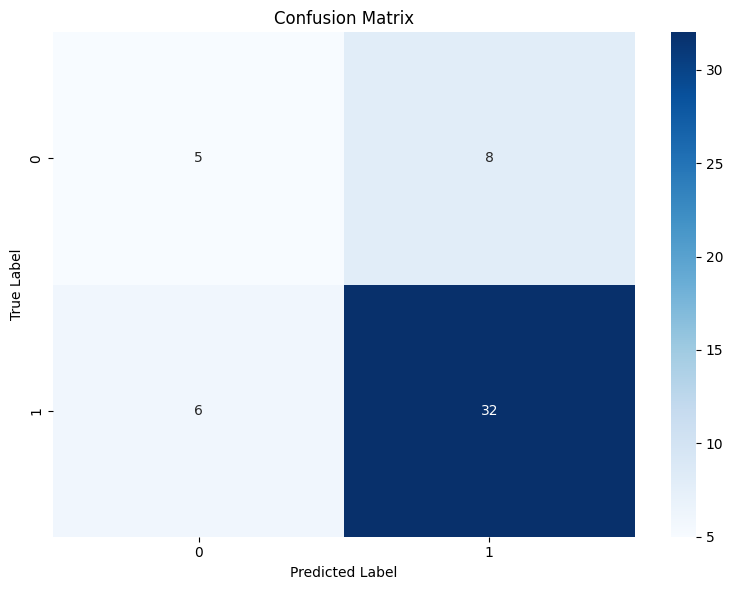

In [11]:

# Initialize and train the Support Vector Classifier (SVC)
svc_classifier = SVC(
    random_state=42, 
    probability=True  # Enables probability estimates for ROC AUC score
)
svc_classifier.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = svc_classifier.predict(X_test)

# Evaluation Metrics
print("\nClassification Report:")
AllFeatures_SVC_report = classification_report(y_test, y_pred)
print(AllFeatures_SVC_report)

# ROC AUC Score
if len(set(y_test)) == 2:  # Check if binary classification for ROC AUC
    y_prob = svc_classifier.predict_proba(X_test)[:, 1]  # Use probabilities for ROC AUC calculation
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc}")
else:
    print("\nROC AUC Score: Not applicable for multi-class classification")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [12]:
# train using the custom SVM model 
svm = SVM(
    learning_rate=0.01,
    n_iters=1000,
)

# train the model
svm.fit(X_train_resampled, y_train_resampled)

# predict the test set
y_pred = svm.predict(X_test)

# Evaluation Metrics
print("\nClassification Report:")
AllFeatures_SVM_report = classification_report(y_test, y_pred)
print(AllFeatures_SVM_report)

# ROC AUC Score
if len(set(y_test)) == 2:  # Check if binary classification for ROC AUC
    y_prob = svm.predict_proba(X_test)  # Use probabilities for ROC AUC calculation
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc}")
    
else:
    print("\nROC AUC Score: Not applicable for multi-class classification")
    
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


KeyError: 0

## 2.2 Method 2: Feature Selection  
Features are selected using three techniques: Wrapper, Embedding, and ANOVA. The union of selected features is used for model training.  

### Sub-methods:  
1. **Wrapper Method**: Backward elimination.  
2. **Embedding Method**: LassoCV.  
3. **ANOVA**: Statistical test for feature importance.  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


In [ ]:
from SelectionType.EFSA.main import FeatureSelector

# Initialize the Feature Selector
selector = FeatureSelector(X_train, y_train)

selected_features = selector.comprehensive_feature_selection(k_features=70) # Perform feature selection based on anova embedding and wrapper methods


print(f"\nSelected Features: {selected_features}")


Selected Features: ['std_6th_delta_delta_mean', 'mean_10th_delta_std', 'apq5Shimmer_mean', 'tqwt_meanValue_dec_25_std', 'IMF_SNR_entropy_mean', 'locDbShimmer_std', 'tqwt_entropy_shannon_dec_11_mean', 'mean_2nd_delta_mean', 'tqwt_minValue_dec_11_mean', 'mean_MFCC_2nd_coef_mean', 'tqwt_minValue_dec_13_mean', 'rapJitter_std', 'std_7th_delta_delta_mean', 'tqwt_maxValue_dec_13_mean', 'tqwt_medianValue_dec_31_std', 'std_delta_delta_log_energy_mean', 'tqwt_kurtosisValue_dec_21_mean', 'tqwt_kurtosisValue_dec_21_std', 'tqwt_medianValue_dec_22_std', 'apq3Shimmer_mean', 'tqwt_entropy_log_dec_35_std', 'tqwt_minValue_dec_10_mean', 'ppq5Jitter_mean', 'tqwt_kurtosisValue_dec_23_mean', 'ddpJitter_mean', 'locAbsJitter_mean', 'tqwt_skewnessValue_dec_35_mean', 'tqwt_kurtosisValue_dec_22_mean', 'tqwt_TKEO_std_dec_11_mean', 'tqwt_medianValue_dec_12_std', 'tqwt_kurtosisValue_dec_36_mean', 'tqwt_kurtosisValue_dec_18_mean', 'tqwt_skewnessValue_dec_17_std', 'apq3Shimmer_std', 'tqwt_kurtosisValue_dec_34_mean',


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.46      0.41        13
           1       0.80      0.74      0.77        38

    accuracy                           0.67        51
   macro avg       0.59      0.60      0.59        51
weighted avg       0.69      0.67      0.68        51


ROC AUC Score: 0.7327935222672065


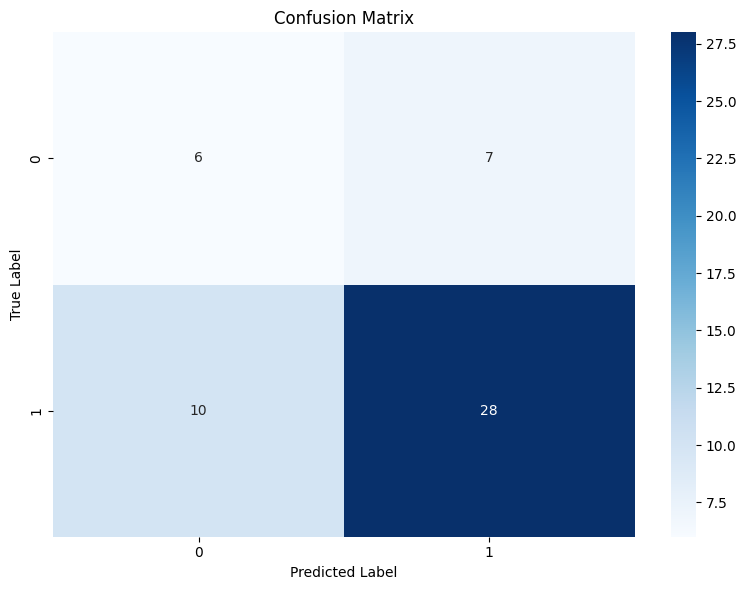

In [ ]:
# train the SVC model using the selected features

svc_classifier = SVC(
    random_state=42, 
    probability=True  # Enables probability estimates for ROC AUC score
)

svc_classifier.fit(X_train_resampled[selected_features], y_train_resampled)

# Predictions
y_pred = svc_classifier.predict(X_test[selected_features])

# Evaluation Metrics
print("\nClassification Report:")
SelectedFeatures_SVC_report = classification_report(y_test, y_pred)
print(SelectedFeatures_SVC_report)


# ROC AUC Score
if len(set(y_test)) == 2:  # Check if binary classification for ROC AUC
    y_prob = svc_classifier.predict_proba(X_test[selected_features])[:, 1]  # Use probabilities for ROC AUC calculation
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc}")
    
else:
    print("\nROC AUC Score: Not applicable for multi-class classification")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## 2.3 Method 3: Dimensionality Reduction  
Principal Component Analysis (PCA) is used to reduce the dataset's dimensionality before applying the **SVM**.   

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


## 3. Comparative Analysis  
- **Objective**: Compare the performance of the **SVM** across:  
  1. All Features.  
  2. Feature Selection.  
  3. PCA.  
- **Comparison Metrics**:  
  - Performance (Accuracy, Precision, Recall, F1-Score, ROC-AUC).  
  - Computational efficiency (Training and Testing Time).  
- Present results as tables and visualizations (e.g., bar plots, ROC curves).  
